# Fairness

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

[This repository](https://github.com/propublica/compas-analysis) the data and analysis pipeline described on [this web page](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [2]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell read the data file:

In [3]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

In [4]:
def make_matrix(cp, subgroup, threshold=4):
    """Make a confusion matrix.
    
    cp: DataFrame
    subgroup: Boolean Series
    
    returns: DataFrame containing the confusion matrix
    """
    a = np.where(cp['decile_score'] > threshold, 
                 'Positive', 
                 'Negative')
    high_risk = pd.Series(a, name='Predicted')
    
    a = np.where(cp['two_year_recid'] == 1, 
                 'Condition', 
                 'No Condition')
    new_charge_2 = pd.Series(a, name='Actual')

    matrix = pd.crosstab(high_risk[subgroup], new_charge_2[subgroup])
    matrix.sort_index(axis=0, ascending=False, inplace=True)
    
    return matrix

In [5]:
def percent(x, y):
    """Compute the percentage `x/(x+y)*100`.
    """
    return x / (x+y) * 100

In [6]:
def predictive_value(m):
    """Compute positive and negative predictive value.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

In [7]:
def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    return sens, spec

In [8]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

In [9]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = df.to_numpy().flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

In [10]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, prev
    df.index.name = name
    return df

In [11]:
def calibration_curve(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

In [12]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [13]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts(dropna=False).sort_index()

## Calibration for male and female defendants

In the previous notebook we saw that COMPAS is nearly calibrated for white and black defendants; that is, the risk scores it assigns correspond to the same probability of recidivism in both groups.

As it turns out the same it not true if we group defendants by sex.

First I'll compute Boolean Series that select male and female defendants:

In [14]:
male = (cp['sex'] == 'Male')
male.mean()

0.8066260049902967

In [15]:
female = (cp['sex'] == 'Female')
female.mean()

0.19337399500970334

Next I'll plot calibration curves for these groups:

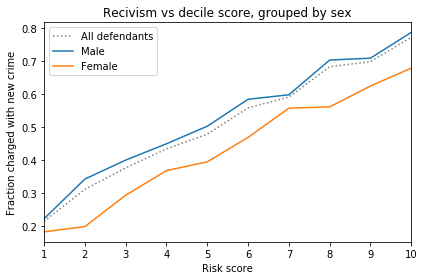

In [17]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_male = calibration_curve(cp[male])
cal_male.plot(label='Male')

cal_female = calibration_curve(cp[female])
cal_female.plot(label='Female')

decorate(xlabel='Risk score',
         ylabel='Fraction charged with new crime',
         title='Recivism vs risk score, grouped by sex')
plt.legend();

For all risk scores, female defendants are substantially less likely to be charged with another crime.

Or, reading the graph the other way, female defendants are given risk scores 1-2 points higher than male defendants with the same actual risk of recidivism.

We can see the same discrepancy in the other metrics.  Here are the confusion matrices for male and female defendants.

In [19]:
matrix_male = make_matrix(cp, male)
matrix_male

Actual,Condition,No Condition
Predicted,,
Positive,1732,994
Negative,1021,2072


In [20]:
matrix_female = make_matrix(cp, female)
matrix_female

Actual,Condition,No Condition
Predicted,,
Positive,303,288
Negative,195,609


And here are the metrics:

In [21]:
metrics_male = compute_metrics(matrix_male, 
                                'Male defendants')
metrics_male

,Percent
Male defendants,
FP rate,32.420091
FN rate,37.086814
PPV,63.536317
NPV,66.989977
Prevalence,47.310534


In [22]:
metrics_female = compute_metrics(matrix_female, 
                                'Female defendants')
metrics_female

,Percent
Female defendants,
FP rate,32.107023
FN rate,39.156627
PPV,51.269036
NPV,75.746269
Prevalence,35.698925


The rate of recidivism (prevalence) is substantially higher for male defendants.

Nevertheless, the error rates for the two groups are about the same.

As a result, the predictive values for the two groups are substantially different:

* PPV: Women classified as high risk are less likely to be charged with another crime, compared to high-risk men (51% vs 64%).

* NPV: Women classified as low risk are more likely to "survive" two years without a new charge, compared to low-risk men (76% vs 67%).

To the degree that COMPAS scores are used to decide which defendants are incarcerated, those decisions 

* Are unfair to women.

* Are less effective than they could be, if they incarcerate lower-risk women while allowing higher-risk men to go free.

## AUC

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

## ROC

One way to do that is to adjust the threshold so the error rates are the same in both groups.

The following function loops through the possible threshold for the low and high risk groups.  For each threshold, it makes the confusion matrix and computes sensitivity and specificity.

In [55]:
thresholds = range(1, 10)
for threshold in thresholds:
    matrix = make_matrix(cp, white, threshold)
    t = sens_spec(matrix)
    print(threshold, t)

1 (85.30020703933747, 36.223118279569896)
2 (73.6024844720497, 52.88978494623656)
3 (63.975155279503106, 64.98655913978494)
4 (52.27743271221532, 76.54569892473118)
5 (40.78674948240166, 85.28225806451613)
6 (29.296066252587995, 90.86021505376344)
7 (20.18633540372671, 94.55645161290323)
8 (11.697722567287784, 96.70698924731182)
9 (4.658385093167702, 98.72311827956989)


When the threshold is low, almost everyone is in the high risk group; in that case:

* Sensitivity is high because most recidivists are in the high risk group, but 

* Specificity is low because most non-recidivists are *also* in the high risk group.

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* Sensitivity is low because most recidivists are in the low risk group, but

* Specificity is high because most non-recidivists are *also* in the low risk group.

One way to visualize these results is to plot sensitivity versus FPR (which is the complement of specificity) for a range of thresholds.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function computes the ROC curve for a given subset of the data:

In [56]:
def make_roc(cp, group):

    thresholds = range(1, 10)
    roc = pd.DataFrame(index=thresholds, 
                   columns=['sens', 'spec'])

    for threshold in thresholds:
        matrix = make_matrix(cp, group, threshold)
        roc.loc[threshold] = sens_spec(matrix)
    
    roc['fpr'] = 100 - roc['spec']
    
    return roc

In [57]:
roc_white = make_roc(cp, white)
roc_white

,sens,spec,fpr
1,85.3002,36.2231,63.7769
2,73.6025,52.8898,47.1102
3,63.9752,64.9866,35.0134
4,52.2774,76.5457,23.4543
5,40.7867,85.2823,14.7177
6,29.2961,90.8602,9.13978
7,20.1863,94.5565,5.44355
8,11.6977,96.707,3.29301
9,4.65839,98.7231,1.27688


In [58]:
roc_black = make_roc(cp, black)
roc_black

,sens,spec,fpr
1,95.213,17.1031,82.8969
2,88.9532,32.3677,67.6323
3,81.3256,43.5655,56.4345
4,72.0147,55.1532,44.8468
5,62.7564,65.6825,34.3175
6,51.4466,75.0975,24.9025
7,38.9795,84.1783,15.8217
8,26.0915,90.5292,9.47075
9,11.9411,96.7131,3.28691


In [59]:
def plot_roc(roc):
    plt.plot(roc['fpr'], roc['sens'])

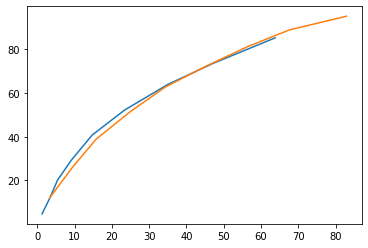

In [60]:
plot_roc(roc_white)
plot_roc(roc_black)

The following function takes `ppv`, `npv`, and `prev` and uses the expressions from `soln1` to compute a confusion matrix with those metrics.

In [201]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value
    npv: negative predictive value
    prev: prevalence
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

In [202]:
all_defendants = np.ones_like(white)
matrix_all = make_matrix(cp, all_defendants)
metrics_all = compute_metrics(matrix_all, 'All defendants')
metrics_all

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


I'll extract PPV, NPV, and prevalence.

In [218]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

Given those values, we can reconstruct the confusion matrix and compute the metrics again.

In [206]:
prev = metrics_black['Percent']['Prevalence']
prev

51.433982683982684

Using this prevalence, and holding PPV and NPV constant, we can compute error rates:

In [207]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(53.40360542740529, 19.955904234916293)

FPR is substantially higher, and FNR substantially lower, compared to the error rates with lower prevalence.

We can do the same analysis for white defendants.

In [208]:
prev = metrics_white['Percent']['Prevalence']

In [209]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(17.254472103643895, 57.81054940714234)

When prevalence is lower, the false positive rate is higher and the false negative rate lower.

In [210]:
ppv, npv = predictive_value(matrix_all)
prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)
    
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

In [211]:
def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

In [213]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
39.364303,23.454301,47.722567
45.065151,32.349230,37.403876
51.433983,44.846797,27.985271


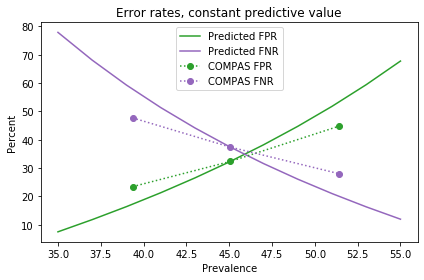

In [215]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [226]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate
    fnr: false negative rate
    prev: prevalence
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

To test it, we can extract metrics for all defendants:

In [227]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)

Now we can see how predictive value depends on prevalence (with error rates held constant).

In [231]:
fpr, fnr = error_rates(matrix_all)
prevalences = np.linspace(35, 65, 11)

pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)
    
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


The following function plots the results.

In [246]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C3')
    pred_pv['npv'].plot(label='Predicted NPV', color='C9')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

If we hold error rates constant and increase prevalence, PPV increases and NPV decreases.

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant error rate model again, along with actual predictive values for white defendants (left), all defendants (middle), and black defendants (right).

In [248]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
39.364303,59.133489,71.187500
45.065151,61.350618,68.796510
51.433983,62.971481,65.045992


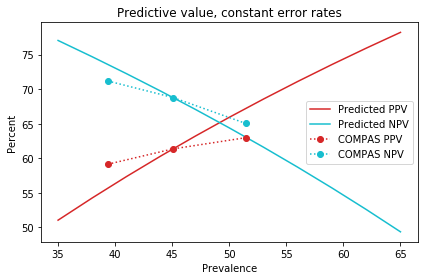

In [249]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C3',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C9',
                      label='COMPAS NPV')

plt.legend();

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.



## What's next?

In [ ]:
def make_dataframe(series, *columns):
    """Make a Series into a DataFrame with one column.
    
    So it looks better in Jupyter.
    
    series: Series
    columns: column name(s)
    
    returns: DataFrame
    """
    df = pd.DataFrame(series.values,
                      index=series.index,
                      columns=columns)
    df.index.name = series.name
    return df

def counts(df, var):
    """Compute counts for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts()
    return make_dataframe(series, 'Count')

def percentages(df, var):
    """Compute percentages for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts() / len(df) * 100
    return make_dataframe(series, 'Percentage')

Breakdown by age

In [ ]:
counts(cp, 'age_cat')

In [ ]:
percentages(cp, 'age_cat')

Breakdown by race

In [ ]:
counts(cp, 'race')

In [ ]:
percentages(cp, 'race')

Breakdown by sex

In [ ]:
counts(cp, 'sex')

In [ ]:
percentages(cp, 'sex')

Breakdown by recidivism

In [ ]:
counts(cp, 'two_year_recid')

In [ ]:
percentages(cp, 'two_year_recid')

Breakdown by risk category

In [ ]:
counts(cp, 'score_text')

In [ ]:
percentages(cp, 'score_text')

The following function computes cross-tabulations.

In [ ]:
def crosstab(df, index, columns):
    """Compute a cross-tabulation.
    
    df: DataFrame
    index: variable(s) that will label the rows
    columns: variable(s) that will label the columns
    
    returns: DataFrame
    """

    xtab = df.pivot_table(index=index, 
                          columns=columns,
                          values='id',
                          aggfunc='count')
    
    return xtab

Breakdown by sex and race

In [ ]:
xtab = crosstab(cp, 'sex', 'race')

Breakdown by age and race

In [ ]:
xtab = crosstab(cp, 'age_cat', 'race')

Breakdown by age and sex

In [ ]:
xtab = crosstab(cp, 'age_cat', 'sex')

Distribution of decile scores for black defendants.

In [ ]:
cp.loc[cp.race=='African-American', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='Black defendant decile scores',
         ylim=[0, 700])

Distribution of decile scores for white defendants.

In [ ]:
cp.loc[cp.race=='Caucasian', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='White defendant decile scores',
         ylim=[0, 700])

Cross tabulation of decile score and race.

In [ ]:
crosstab(cp, 'decile_score', 'race')

Cross tabulation of decile score and age group.

In [ ]:
crosstab(cp, 'decile_score', 'age_cat')

Here's the confusion matrix with all three score categories.

In [ ]:
crosstab(cp, 'two_year_recid', 'score_text')

To make sure I've got the data right, I'll reproduce the confusion matrices from the article.

In [ ]:
def compute_matrix(df):
    """Compute a confusion matrix from data.
    
    df: DataFrame
    
    returns: confusion matrix
    """
    high = cp.score_text.isin(['Medium', 'High']).astype(int)
    return crosstab(df, 'two_year_recid', high)

All defendants.

In [ ]:
compute_matrix(cp)

And the differences are 0.

In [ ]:
matrix_all - compute_matrix(cp).values

Black defendants.

In [ ]:
black = cp[cp.race=='African-American']
compute_matrix(black)

In [ ]:
matrix_black - compute_matrix(black).values

White defendants.

In [ ]:
white = cp[cp.race=='Caucasian']
compute_matrix(white)

In [ ]:
matrix_white - compute_matrix(white).values

### Comparing reality to the CPV model

In this section I'll compare actual PPV and FPR for a variety of subgroups to the values we would expect based on the CPV model; that is, a model where the predictive values are the same for all groups.

The following function groups defendants by `group_vars` and returns a table with one row for each group.

In [ ]:
def make_table(df, group_vars, expected_ppv, expected_npv):
    """Make a table with one line per group.
    
    df: DataFrame
    group_vars: string or list of string variable names
    expected_ppv: 
    expected_npv:
    
    returns: table
    """
    # make the DataFrame
    columns = ['count', 'prevalence',
               'actual PPV', 'actual NPV', 'actual FNR',
               'actual FPR', 'expected FPR', 'difference']
    columns = group_vars + columns 

    table = pd.DataFrame(columns=columns)

    # loop through the groups
    grouped = df.groupby(group_vars)
    for i, (name, group) in enumerate(grouped):
        if not isinstance(name, tuple):
            name = name,
        
        # size of group
        count = len(group)
        
        # compute metrics
        matrix = compute_matrix(group)
        prev = prevalence(matrix)
        actual_ppv, actual_npv = predictive_value(matrix)
        actual_fpr, actual_fnr = error_rates(matrix)

        # generate the CPV matrix
        cpv = constant_predictive_value(prev, 
                          expected_ppv, expected_npv)

        # get the expected error rates
        expected_fpr, _ = error_rates(cpv * 100)
        
        # for very low and high prevalences, it might
        # not be possible to achieve given predictive values
        if expected_fpr < 0:
            expected_fpr = 0

        if expected_fpr > 100:
            expected_fpr = 100

        # difference between actual and expected
        diff = actual_fpr - expected_fpr

        # add a row to the table
        row = name + (count, prev,
                      actual_ppv, actual_npv, actual_fnr,
                      actual_fpr, expected_fpr, diff)
        
        table.loc[i] = row
        
    # sort the table by prevalence
    table.sort_values(by='prevalence', inplace=True)
    return table

In [ ]:
subset = cp[cp.race.isin(['African-American', 'Caucasian'])]
subset.shape

Here's the breakdown by age category.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat']
table1 = make_table(subset, group_vars, ppv, npv)

Again, the actual behavior of the test is tempered, compare to the CPV model; that is, the results are less extreme than the model expects.

Here's the breakdown by race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race']
table2 = make_table(subset, group_vars, ppv, npv)

The false positive rate for whites is higher than we would expect if predictive value were the same for all groups.

The false positive rate for blacks is lower than we would expect.

Here's the breakdown by sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['sex']
table3 = make_table(subset, group_vars, ppv, npv)

The false positive rate for women is substantially higher than what we would expect in the CPV model, which is consistent with the calibration results in the previous section.

Here's the breakdown by age and race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race']
table4 = make_table(subset, group_vars, ppv, npv)

Breakdown by age and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'sex']
table5 = make_table(subset, group_vars, ppv, npv)

Breakdown by race and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race', 'sex']
table6 = make_table(subset, group_vars, ppv, npv)

Breakdown by age, race, and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race', 'sex']
table7 = make_table(subset, group_vars, ppv, npv)

Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

In [ ]:
tables = [table1, table2, table3, table4, table5, table6, table7];

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [ ]:
def plot_table_var(table, var, color):
    """Plot one data point per row.
    
    table: DataFrame
    var: which metric to plot
    color: string
    """
    for _, row in table.iterrows():
        alpha = 0.8 if row['count'] > 200 else 0.3

        plt.plot(row['prevalence'], row[var],
                 'o', color=color, alpha=alpha)

Here's what the results look like for FPR.

In [ ]:
fp_rates.plot(label='Expected FPR, constant CPV',
              color='C1')
plt.axhline(fpr, linestyle='dotted', 
            label='Expected FPR, constant FPR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FPR', 'C1')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False positive rates by subgroup')

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

In [ ]:
ppv_rates.plot(label='Expected PPV, constant FPR', color='C0')
plt.axhline(ppv, linestyle='dotted', 
            label='Expected PPV, constant PPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual PPV', 'C0')
    
decorate(xlabel='Prevalence',
         ylabel='Rate',
         title='Positive predictive value by subgroup')

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

In [ ]:
fn_rates.plot(label='Expected FNR, constant CPV',
              color='C4')
plt.axhline(fnr, linestyle='dotted', 
            label='Expected FNR, constant FNR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FNR', 'C4')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False negative rates by subgroup')

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

In [ ]:
npv_rates.plot(label='Expected NPV, constant FPR', color='C2')
plt.axhline(npv, linestyle='dotted', 
            label='Expected NPV, constant NPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual NPV', 'C2')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='Negative predictive value by subgroup')

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.

### Individual FPR

In [ ]:
from scipy.interpolate import interp1d

def crossing(series, value, **options):
    """Find where a function crosses a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.values, series.index, **options)
    return interp(value)

def interpolate(series, value, **options):
    """Evaluate a function at a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.index, series.values, **options)
    return interp(value)

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
crossing(cal_all, 0.4)

In [ ]:
crossing(cal_all, 0.7)

In [ ]:
interpolate(cal_all, 3.4)

In [ ]:
interpolate(cal_all, 9)

In [ ]:
def make_error_dist(std_dev):
    """Make a discrete Gaussian distribution.
    
    std_dev: standard deviation
    
    returns: Series that maps errors to probabilities
    """
    errors = np.linspace(-3, 3, 21)
    prob_error = np.exp(-(errors/std_dev)**2)
    prob_error /= np.sum(prob_error)
    error_dist = pd.Series(prob_error, index=errors)
    return error_dist

In [ ]:
error_dist = make_error_dist(std_dev=2)
error_dist.plot(label='')
decorate(xlabel='Error (score)',
         ylabel='Probability')

In [ ]:
def individual_fpr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'not low' | error
        prob_positive = 0 if score < thresh else 1

        # probability of being a false positive | error
        prob_fp = prob_positive * (1-actual_prob_recid)
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fpr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fpr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FPR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fpr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fpr = individual_fpr(prob_recid, cal, thresh, std_dev)
        prob_fpr_series[prob_recid] = fpr
    return prob_fpr_series

In [ ]:
s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false positive')

In [ ]:
def individual_fpr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifpr = individual_fpr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifpr
    return total_prob

In [ ]:
individual_fpr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifpr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fpr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifpr_series = pd.Series(t, scores)
    return ifpr_series

In [ ]:
thresh = 4.5

s = make_ifpr_series(cal_all, thresh, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = make_ifpr_series(cal_all, thresh, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
def assign_individual_fpr(df, cal, thresh, std_dev):
    """Assign individual FPRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifpr_series = make_ifpr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifpr'] = [ifpr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_cdf(series):
    """Make a CDF."""
    counts = series.value_counts().sort_index()
    counts /= counts.sum()
    return counts.cumsum()

def plot_cdf(cdf, **options):
    """Plot a CDF as a step function."""
    plt.step(cdf.index, cdf.values, where='post', **options)

In [ ]:
cdf_ifpr = make_cdf(cp.ifpr)

In [ ]:
plot_cdf(cdf_ifpr, label='All')

decorate(xlabel='Individual probability of false positive', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
black = cp[cp.race=='African-American']
white = cp[cp.race=='Caucasian']

thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifpr_series(cal_black, thresh, std_dev)
s.plot(label='FPR, black')

cal_white = calibration_curve(white)
s = make_ifpr_series(cal_white, thresh, std_dev)
s.plot(label='FPR, white')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
male = cp[cp.sex=='Male']
female = cp[cp.sex=='Female']

thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifpr_series(cal_male, thresh, std_dev)
s.plot(label='FPR, male')

cal_female = calibration_curve(female)
s = make_ifpr_series(cal_female, thresh, std_dev)
s.plot(label='FPR, female')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

### Individual FNR

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
def individual_fnr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'low' | error
        prob_negative = 0 if score >= thresh else 1

        # probability of being a false negative | error
        prob_fp = prob_negative * actual_prob_recid
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fnr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fnr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FNR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fnr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fnr = individual_fnr(prob_recid, cal, thresh, std_dev)
        prob_fnr_series[prob_recid] = fnr
    return prob_fnr_series

In [ ]:
s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false negative')

In [ ]:
def individual_fnr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifnr = individual_fnr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifnr
    return total_prob

In [ ]:
individual_fnr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifnr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fnr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifnr_series = pd.Series(t, scores)
    return ifnr_series

In [ ]:
thresh = 4.5

s = make_ifnr_series(cal_all, thresh, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = make_ifnr_series(cal_all, thresh, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
def assign_individual_fnr(df, cal, thresh, std_dev):
    """Assign individual FNRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifnr_series = make_ifnr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifnr'] = [ifnr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
cdf_ifnr = make_cdf(cp.ifnr)

In [ ]:
plot_cdf(cdf_ifnr, label='All')

decorate(xlabel='Individual probability of false negative', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifnr_series(cal_black, thresh, std_dev)
s.plot(label='FNR, black')

cal_white = calibration_curve(white)
s = make_ifnr_series(cal_white, thresh, std_dev)
s.plot(label='FNR, white')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifnr_series(cal_male, thresh, std_dev)
s.plot(label='FNR, male')

cal_female = calibration_curve(female)
s = make_ifnr_series(cal_female, thresh, std_dev)
s.plot(label='FNR, female')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

### What would it take?

In this section I explore what it would take to make a test with the same false positive rate for all groups.

In [ ]:
def fpr_thresh(df, thresh):
    df = df.copy()
    df['high'] = df.decile_score >= thresh
    matrix_all = crosstab(df, 'two_year_recid', 'high')
    fpr, fnr = error_rates(matrix_all)
    return fpr

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(white, 5)

In [ ]:
def sweep_thresh(df):
    threshes = range(2,10)
    sweep = pd.Series(index=threshes)
    for thresh in threshes:
        sweep[thresh] = fpr_thresh(df, thresh)
        
    return sweep

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(cp).plot(label='All')
sweep_thresh(black).plot(label='Black')
sweep_thresh(white).plot(label='White')
decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
def find_threshold(group, fpr):
    series = sweep_thresh(group)
    xs = crossing(series.dropna(), fpr)
    return xs

In [ ]:
all_thresh = find_threshold(cp, 32.35)

In [ ]:
black_thresh = find_threshold(black, 32.35)

In [ ]:
white_thresh = find_threshold(white, 32.35)

In [ ]:
interpolate(calibration_curve(cp), all_thresh)

In [ ]:
interpolate(calibration_curve(cp), black_thresh)

In [ ]:
interpolate(calibration_curve(black), black_thresh)

In [ ]:
interpolate(calibration_curve(cp), white_thresh)

In [ ]:
interpolate(calibration_curve(white), white_thresh)

In [ ]:
black_male = black[black.sex=='Male']
black_male.shape

In [ ]:
black_female = black[black.sex=='Female']
black_female.shape

In [ ]:
old_black_female = black_female[black_female.age_cat=='Greater than 45']
old_black_female.shape

In [ ]:
old_white_female = cp[(cp.age_cat=='Greater than 45') &
                      (cp.sex=='Female') &
                      (cp.race=='Caucasian')]
old_white_female.shape

In [ ]:
young_black_male = cp[(cp.age_cat=='Less than 25') &
                      (cp.sex=='Male') &
                      (cp.race=='African-American')]
young_black_male.shape

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(black_female, 5)

In [ ]:
fpr_thresh(old_black_female, 5)

In [ ]:
fpr_thresh(black_male, 5)

In [ ]:
fpr_thresh(young_black_male, 5)

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_male).plot(label='Black male')
sweep_thresh(young_black_male).plot(label='Young black male')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_female).plot(label='Black female')
sweep_thresh(old_black_female).plot(label='Old black female')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
ybm_thresh = find_threshold(young_black_male, 32.35)

In [ ]:
obf_thresh = find_threshold(old_black_female, 32.35)

In [ ]:
interpolate(calibration_curve(cp), ybm_thresh)

In [ ]:
interpolate(calibration_curve(cp), obf_thresh)

To see what this kind of unfairness looks like, I'll generate the same figure, grouping defendants by sex.

In [ ]:
male = (cp['sex'] == 'Male')
male.mean()

In [ ]:
female = (cp['sex'] == 'Female')
female.mean()

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_male = calibration_curve(cp[male])
cal_male.plot(label='Male')

cal_female = calibration_curve(cp[female])
cal_female.plot(label='Female')

decorate(xlabel='Risk score',
         ylabel='Prob recidivism',
         title='Recivism vs decile score, grouped by sex')
plt.legend();

For all risk scores, female defendants are substantially less likely to recidivate than male defendants.

Or, reading the graph the other way, female defendants are given decile scores 1-2 points higher than male defendants with the same actual risk of recidivism.

## AUC

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

## ROC

One way to do that is to adjust the threshold so the error rates are the same in both groups.

The following function loops through the possible threshold for the low and high risk groups.  For each threshold, it makes the confusion matrix and computes sensitivity and specificity.

In [ ]:
thresholds = range(1, 10)
for threshold in thresholds:
    matrix = make_matrix(cp, white, threshold)
    t = sens_spec(matrix)
    print(threshold, t)

When the threshold is low, almost everyone is in the high risk group; in that case:

* Sensitivity is high because most recidivists are in the high risk group, but 

* Specificity is low because most non-recidivists are *also* in the high risk group.

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* Sensitivity is low because most recidivists are in the low risk group, but

* Specificity is high because most non-recidivists are *also* in the low risk group.

One way to visualize these results is to plot sensitivity versus FPR (which is the complement of specificity) for a range of thresholds.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function computes the ROC curve for a given subset of the data:

In [ ]:
def make_roc(cp, group):

    thresholds = range(1, 10)
    roc = pd.DataFrame(index=thresholds, 
                   columns=['sens', 'spec'])

    for threshold in thresholds:
        matrix = make_matrix(cp, group, threshold)
        roc.loc[threshold] = sens_spec(matrix)
    
    roc['fpr'] = 100 - roc['spec']
    
    return roc

In [ ]:
roc_white = make_roc(cp, white)
roc_white

In [ ]:
roc_black = make_roc(cp, black)
roc_black

In [ ]:
def plot_roc(roc):
    plt.plot(roc['fpr'], roc['sens'])

In [ ]:
plot_roc(roc_white)
plot_roc(roc_black)